# Import thư viện

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

# Set matplotlib figure size
plt.rcParams['figure.figsize'] = (20, 4)

# Đọc dữ liệu

In [50]:
# Power dataframe
p_df = pd.read_csv('./data/W.csv',\
                       names=['time', 'light', 'socket', 'heater', 'aircond1', 'aircond2', 'aircond3', 'indcooker'],\
                       header=0)
# Voltage dataframe
u_df = pd.read_csv('./data/V.csv',\
                  names=['time', 'u'],\
                  header=0)
# Current dataframe
i_df = pd.read_csv('./data/A.csv',\
                  names=['time', 'light', 'socket', 'heater', 'aircond1', 'aircond2', 'aircond3', 'indcooker'],\
                  header=0)
# Power factor dataframe
pf_df = pd.read_csv('./data/cosphi.csv',\
                       names=['time', 'light', 'socket', 'heater', 'aircond1', 'aircond2', 'aircond3', 'indcooker'],\
                       header=0)

# Reactive power dataframe
q_df = pd.DataFrame()
q_df['time'] = p_df['time']
column_names = ['light', 'socket', 'heater', 'aircond1', 'aircond2', 'aircond3', 'indcooker']

# Calculate reactive power using P and cosphi
for col_name in column_names:
    q_df[col_name] = np.tan(np.arccos(pf_df[col_name])) * p_df[col_name]

light    : chiếu sáng  
socket   : ổ cắm phòng khách + bếp + ngủ  
heater   : bình nóng lạnh  
aircond1 : điều hoà 1 & 2  
aircond2 : điều hoà 3  
aircond3 : điều hoà phòng khách  
indcooker: bếp từ  

### Chọn thiết bị phân loại

In [51]:
# select_device = ['heater', 'indcooker']
# select_device = ['heater', 'indcooker', 'aircond1']
# select_device = ['heater', 'indcooker', 'aircond1', 'aircond2', 'aircond3']
select_device = ['heater', 'indcooker', 'aircond1', 'aircond2', 'aircond3', 'socket', 'light']


## Tính tổng P, Q, I

In [52]:
p_sum = p_df[select_device].sum(axis=1).to_numpy()
q_sum = q_df[select_device].sum(axis=1).to_numpy()
u_sum = u_df['u'].to_numpy()  # không cần tính tổng U, nhưng cứ đặt là u_sum cho đồng nhất
i_sum = i_df[select_device].sum(axis=1).to_numpy() * 100  # Nhân với 100 để I không quá nhỏ 

### Đồ thị công suất

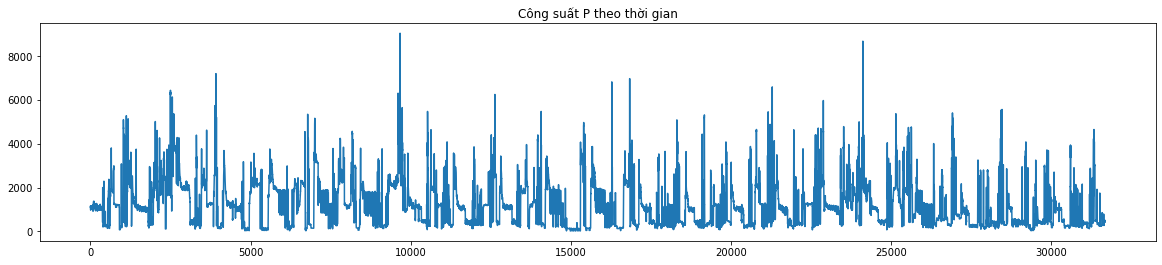

In [53]:
plt.title("Công suất P theo thời gian")
plt.plot(p_sum)

# Chuẩn bị tập dữ liệu

Tại mỗi thời điểm t, tính `delta P = P[t] - P[t-1]`, `delta Q = Q[t] - Q[t-1]`  

Xác định nhãn lớp bằng cách kiểm tra đồ thị công suất của từng thiết bị, nếu lớn hơn mức ngưỡng thì thiết bị đó là bật.

Rồi thêm vào tập dữ liệu

In [54]:
data = []
label = []
threshold = 10  # ngưỡng xác định thiết bị là bật > 10W
for i in range(1, len(p_sum)):
    delta_p = p_sum[i] - p_sum[i-1]
    delta_q = q_sum[i] - q_sum[i-1]
    data.append([u_sum[i], i_sum[i], p_sum[i], q_sum[i], delta_p, delta_q])
    x = 0
    for j, device_name in enumerate(select_device):
        if p_df[device_name].iloc[i] > threshold:
            x += 2**j

    label.append(x)
        
print("num data point =", len(data))

num data point = 31679


### Đưa label về dạng vector 0, 1

Ví dụ có 5 thiết bị: A, B, C, D, E:
- A đang bật => 1
- B đang tắt => 0
- C đang bật => 1
- D đang bật => 1
- E đang tắt => 0

Thì nhãn lớp là vector [1,0,1,1,0]

In [55]:
# Hàm chuyển đổi nhãn lớp về dạng vector 

# VD có 5 thiết bị   
# tobase2(3) sẽ trả về [0, 0, 0, 1, 1]

def tobase2(n):
    length = len(select_device)
    ret = [0 for i in range(length)]
    i = length - 1
    while n > 0:
        ret[i] = n % 2
        n = n // 2
        i -= 1
    return ret

X = data
y = [tobase2(label[i]) for i in range(len(label))]

## Bảng dữ liệu đã chuẩn hoá

In [56]:
data_df = pd.DataFrame(data=X, columns=['delta P', 'delta Q', 'P', 'Q', 'U', 'I'])
data_df['label'] = y
data_df

,delta P,delta Q,P,Q,U,I,label
0,230,559.5,1130.5,510.836704,38.5,-21.351676,"[0, 1, 1, 0, 1, 0, 0]"
1,230,559.0,1159.0,462.989261,28.5,-47.847443,"[0, 1, 1, 0, 1, 0, 0]"
2,230,560.0,1095.5,574.102699,-63.5,111.113439,"[0, 1, 1, 0, 1, 0, 0]"
3,230,543.0,1064.0,561.588237,-31.5,-12.514463,"[0, 1, 1, 0, 1, 0, 0]"
4,230,525.5,1086.0,405.119945,22.0,-156.468291,"[0, 1, 1, 0, 1, 0, 0]"
...,...,...,...,...,...,...,...
31674,230,248.0,420.0,303.805554,-53.0,69.748154,"[0, 1, 0, 0, 1, 0, 0]"
31675,230,248.0,413.0,304.469537,-7.0,0.663983,"[0, 1, 0, 0, 1, 0, 0]"
31676,231,249.0,443.0,273.435954,30.0,-31.033583,"[0, 1, 0, 0, 1, 0, 0]"
31677,231,249.0,471.0,252.311746,28.0,-21.124208,"[0, 1, 0, 0, 1, 0, 0]"


### Phân bố nhãn lớp

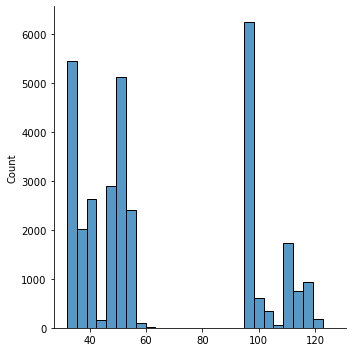

In [57]:
import seaborn as sns
sns.displot(label)

# Chia tập train, test

Tỷ lệ chia 70-30, lấy theo thứ tự, không xáo trộn (để dễ dàng so sánh kết quả với các giải thuật hoặc mô hình khác)

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, shuffle=False)

## Train

In [59]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', 
                    alpha=1e-5, 
                    hidden_layer_sizes=30, 
                    random_state=1, 
                    max_iter=1000, 
                    verbose=True, 
                    learning_rate='adaptive',
                    n_iter_no_change=20)
clf.fit(X_train, y_train)

Iteration 1, loss = 56.19839263
Iteration 2, loss = 22.66744706
Iteration 3, loss = 18.98342033
Iteration 4, loss = 15.17174286
Iteration 5, loss = 13.86807048
Iteration 6, loss = 13.64533830
Iteration 7, loss = 10.64845625
Iteration 8, loss = 9.20335539
Iteration 9, loss = 10.51894468
Iteration 10, loss = 9.41795687
Iteration 11, loss = 8.81494778
Iteration 12, loss = 8.71871516
Iteration 13, loss = 8.18992642
Iteration 14, loss = 8.28495189
Iteration 15, loss = 7.25357966
Iteration 16, loss = 6.91204336
Iteration 17, loss = 7.86560916
Iteration 18, loss = 8.89429930
Iteration 19, loss = 7.39122856
Iteration 20, loss = 6.96868756
Iteration 21, loss = 6.66572760
Iteration 22, loss = 7.02263899
Iteration 23, loss = 12.68114268
Iteration 24, loss = 8.59126622
Iteration 25, loss = 7.96189460
Iteration 26, loss = 7.62226491
Iteration 27, loss = 7.58229633
Iteration 28, loss = 7.50965045
Iteration 29, loss = 9.30487131
Iteration 30, loss = 7.83157793
Iteration 31, loss = 6.96002125
Iteratio

MLPClassifier(alpha=1e-05, hidden_layer_sizes=30, learning_rate='adaptive',
              max_iter=1000, n_iter_no_change=20, random_state=1, verbose=True)

# Test

Độ chính xác của mô hình

In [60]:
clf.score(X_test, y_test)

0.19518097643097643